# HowTo-1-DownloadingImageCutouts

### At first we will try to import the qso_toolbox modules:

In [1]:
from qso_toolbox import catalog_tools as ct, image_tools as it, photometry_tools as pt, utils as ut

loading dl.conf


### If you encountered an error loading these modules, please check whether all the import python packages are successfully installed on your system.

## 0) The examples files 
### We have prepared example tables to test the qso_toolbox modules with: 

### A) stripe82_milliquas_190210.hdf5 
(stripe82_milliquas_190210.csv, stripe82_milliquas_190210.fits)

### This file contains all confirmed quasars within the Milliquas catalog (from Feb 10th 2019, intermediate release; https://heasarc.gsfc.nasa.gov/W3Browse/all/milliquas.html), which fall within the Stripe 82 footprint. This file includes the following columns: [RA:'mq_ra', Dec:'mq_dec, Name:'mq_name', Redshift:'mq_z', Reference:'mq_cite'].

### The example below shows how to read these files into a pandas DataFrame. The qso_toolbox modules natively work with pandas dataframes. However, as long as the tables are either  an astropy record array or a fits record array, they will be converted inside the modules.


In [2]:
import pandas as pd 
from astropy.io import fits 
from astropy.table import Table

df_hdf = pd.read_hdf('./data/stripe82_milliquas_190210.hdf5',key='data')
print(df_hdf[:2])

df_csv = pd.read_csv('./data/stripe82_milliquas_190210.csv')
print(df_csv[:2])

hdu = fits.open('./data/stripe82_milliquas_190210.fits')
t = Table(hdu[1].data)
df_fits = t.to_pandas()
print(df_fits[:2])

      mq_ra    mq_dec                   mq_name   mq_z mq_cite
0  0.006464 -0.559066  SDSS J000001.55-003332.6  2.219   DR14Q
1  0.006855  0.583184  SDSS J000001.64+003459.4  2.271   DR14Q
      mq_ra    mq_dec                   mq_name   mq_z mq_cite
0  0.006464 -0.559066  SDSS J000001.55-003332.6  2.219   DR14Q
1  0.006855  0.583184  SDSS J000001.64+003459.4  2.271   DR14Q
      mq_ra    mq_dec                   mq_name   mq_z mq_cite
0  0.006464 -0.559066  SDSS J000001.55-003332.6  2.219   DR14Q
1  0.006855  0.583184  SDSS J000001.64+003459.4  2.271   DR14Q


## 1) Downloading a sample of cutouts 

### The function inside the catalog_tools.py that is responsible for downloading image cutouts is called "catalog_tools.get_photometry()".

### Here is the beginning of the function definition for an overview:

def get_photometry(table, ra_col_name, dec_col_name, surveys, bands, image_path,
                   fovs,
                   verbosity=0):
    
    """Download photometric images for all objects in the given input table.

    Lists need to be supplied to specify the survey, the photometric passband
    and the field of fiew. Each entry in the survey list corresponds to one
    entry in the passband and field of view lists.
    
    The downloaded images will be save in the image_path directory using a
    unique filename based on the target position, survey + data release,
    passband and field of view.

    Image name
    [Epoch Identifier][RA in HHMMSS.SS][DEC in DDMMSS.SS]_
                                 [SURVEY]_[PASSBAND]_fov[FIELD OF VIEW].fits
    
    A example for DES DR1 z-band with a field of view of 100 arcsec:
    J224029.28-000511.83_desdr1_z_fov100.fits

    The list of field of views will be accurately downloaded for desdr1. For
    the download of the unWISE image cutouts the field of views will be
    converted to number of pixels with npix = fov / 60. /4. * 100, with an
    upper limit of 256 pixels.
    
    IMPORTANT:
    The function will skip downloads for targets with exactly the same 
    specifications (filenames) that already exist in the folder.

    :param table: table object
        Input data table with at least RA and Decl. columns
    :param ra_col_name: string
        Exact string for the RA column in the table
    :param dec_col_name: string
        Exact string for the Decl. column in the table
    :param surveys: list of strings
        List of survey names, length has to be equal to bands and fovs
    :param bands: list of strings
        List of band names, length has to be equal to surveys and fovs
    :param image_path: string
        Path to the directory where all the images will be stored
    :param fovs: list of floats
        Field of view in arcseconds, length has be equal to surveys and bands
    :param verbosity:
        Verbosity > 0 will print verbose statements during the execution
    :return: None
    """

### We will now create a 'cutouts' directory in this folder, where the cutouts will be saved.

In [3]:
! mkdir cutouts 
! ls 

mkdir: cutouts: File exists
GettingStarted.ipynb
HowTo-1-DownloadingImageCutouts.ipynb
HowTo-2-CalculatingForcedPhotometry.ipynb
HowTo-3-OffsetStarsAndFindingCharts.ipynb
Untitled.ipynb
cutouts
data
imviewgui_example.py
mp_test.py
temp.hdf5
tmp.tar.gz


### We first choose a subset of Stripe 82 to make sure not to download over 35000 cutouts per band.

In [4]:
test_set = df_hdf.query('340 < mq_ra < 350 and -1.26 < mq_dec < 0')
print(test_set.shape)

(1344, 5)


### Now we can begin to download some image cutouts. We will download DES DR1 z-band, PS1 g-band and UNWISE W1-band cutouts for a start. Before we can call the function we need to specify the surveys, bands and field of views. We will set verbosity to 2, to see what the code does on it's way.

In [5]:
surveys = ['unwise-neo3','ps1', 'desdr1', 'vhsdr6']
bands = ['w1','g','z', 'Ks']
fovs = [100, 100, 100, 100]

ct.get_photometry(test_set[:10], 'mq_ra', 'mq_dec', surveys, bands, './cutouts/', fovs, verbosity=2)

/Users/schindler/anaconda3/lib/python3.6/site-packages/qso_toolbox/catalog_tools.py:918: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  epoch="J")


## 2) Downloading cutouts using multiprocessing

### If the code successfully downloaded the cutouts for these 10 targets, let's do it for another 100. However, in this case we compare the function used above to it's multiprocessing capable version "get_photometry_mp". And for fun we will time the runs of both functions, each downloading 50 cutouts. We will set the number of jobs ('n_jobs') to 5. Please change this depending on your CPU capabilities. We further set verbosity to 0, to not be overrun by internal messages.

### <font color=red>Attention: Using more jobs than you have cores may lead to errors in the downloading process!!!</font>

In [6]:
import time 

surveys = ['unwise-neo3','ps1','desdr1']
bands = ['w1','g','z']
fovs = [100, 100, 100]

# Normal run 
start_time = time.time()
ct.get_photometry(test_set[10:60], 'mq_ra', 'mq_dec', surveys, bands, './cutouts/', fovs, verbosity=0)
print("Elapsed time: {0:.2f} sec" .format(
                                time.time() - start_time))

# Multiprocessing run 
start_time = time.time()
ct.get_photometry_mp(test_set[60:110], 'mq_ra', 'mq_dec', surveys, bands, './cutouts/', fovs, n_jobs=3, verbosity=0)
print("Elapsed time: {0:.2f} sec" .format(
                                time.time() - start_time))

HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
Elapsed time: 64.43 sec


/Users/schindler/anaconda3/lib/python3.6/site-packages/qso_toolbox/catalog_tools.py:1085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  epoch="J")


HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
HTTP Error 500: Internal Server Error
Elapsed time: 52.55 sec


### You should be able to see a better performance by the multiprocessing version of the get_photometry routine. We can now have a quick look at the files in the folder 

### In some cases it is possible that the download will not succeed, because it experiences server errors. For example the infamous "HTTP Error 500: Internal Server Error".
### I have no idea on how to get around that. :-(

## 3) Displaying image cutouts

### The image_tools.py module contains functions to display the downloaded image cutouts with. We will show an example of below. Please have a look at the function header to familiarize yourself with the args and kwargs.

def make_mult_png_fig(ra, dec, surveys, bands,
                  fovs, apertures, square_sizes, image_folder_path, mag_list=None,
                  magerr_list=None, sn_list=None,
                  forced_mag_list=None, forced_magerr_list=None,
                  forced_sn_list=None, n_col=3,
                  n_sigma=3, color_map_name='viridis',
                  add_info_label=None, add_info_value=None, verbosity=0):
    """Create a figure to plot cutouts for one source in all specified surveys
    and bands.

    :param ra: float
        Right Ascension of the target
    :param dec: float
        Declination of the target
     :param surveys: list of strings
        List of survey names, length has to be equal to bands and fovs
    :param bands: list of strings
        List of band names, length has to be equal to surveys and fovs
    :param fovs: list of floats
        Field of view in arcseconds of image cutouts, length has be equal to
        surveys, bands and apertures.
    :param apertures: list of floats
        List of apertures in arcseconds for forced photometry calculated,
        length has to be equal to surveys, bands and fovs
    :param square_sizes: list of floats
        List of
    :param image_folder_path: string
        Path to the directory where all the images are be stored
    :param mag_list: list of floats
        List of magnitudes for each survey/band
    :param magerr_list: list of floats
         List of magnitude errors for each survey/band
    :param sn_list: list of floats
         List of S/N for each survey/band
    :param forced_mag_list: list of floats
         List of forced magnitudes for each survey/band
    :param forced_magerr_list: list of floats
        List of forced magnitude errors for each survey/band
    :param forced_sn_list: list of floats
        List of forced S/N for each survey/band
    :param n_col: int
        Number of columns
    :param n_sigma: int
        Number of sigmas for the sigma-clipping routine that creates the
        boundaries for the color map.
    :param color_map_name: string
        Name of the color map
    :param add_info_value : string
        Value for additional information added to the title of the figure
    :param add_info_label : string
        Label for additional information added to the title of the figure
    :param verbosity:
        Verbosity > 0 will print verbose statements during the execution
    :return: matplotlib.figure
        Figure with the plot.
    """


### Example (basic):

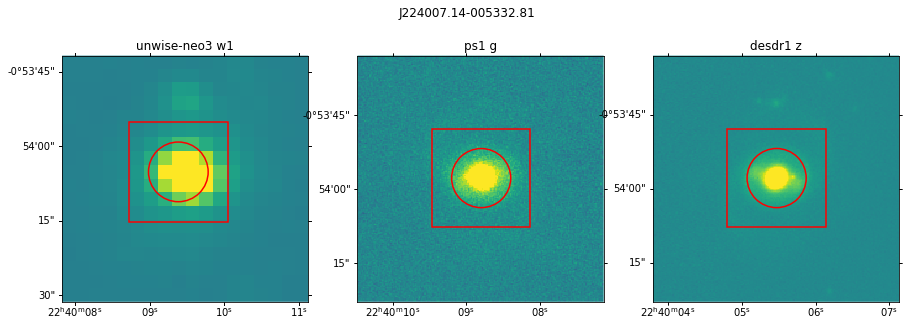

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl 

%matplotlib inline

ra = test_set.loc[test_set.index[0],'mq_ra']
dec = test_set.loc[test_set.index[0],'mq_dec']

surveys = ['unwise-neo3','ps1', 'desdr1']
bands = ['w1','g','z']
fovs = [50, 50, 50]
apertures = [6, 6, 6]
square_sizes = [20, 20, 20]

fig = it.make_mult_png_fig(ra, dec, surveys, bands,
                  fovs, apertures, square_sizes, './cutouts/', n_col=3,
                  n_sigma=3, color_map_name='viridis', verbosity=0)

### Example (with additional information):

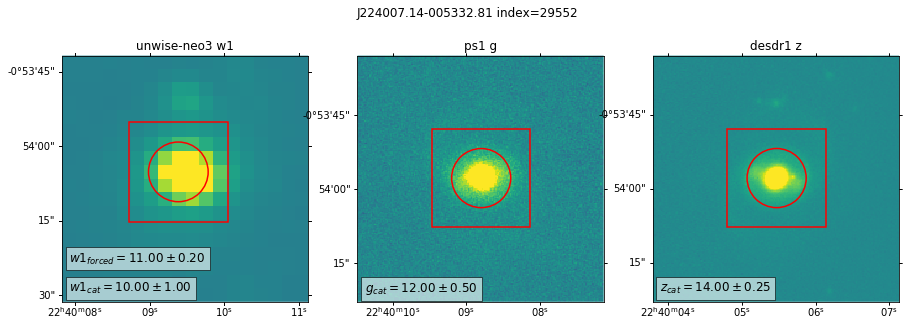

In [8]:
# Additional information can be added to the plot
add_info_label = "index"
add_info_value = str(test_set.index[0])
# The following values are not true and just for display purposed
mag_list = [10, 12, 14]
magerr_list = [1,0.5,0.25]

fmag_list = [11, None, None]
fmage_list = [0.2, None, None]


fig = it.make_mult_png_fig(ra, dec, surveys, bands,
                  fovs, apertures, square_sizes, './cutouts/', n_col=3,
                  n_sigma=3, add_info_label= add_info_label, add_info_value=add_info_value,
                  mag_list=mag_list,
                  magerr_list=magerr_list,
                  forced_mag_list=fmag_list,
                  forced_magerr_list=fmage_list,
                  color_map_name='viridis', verbosity=0)


# 4) TODO Saving Cutout Plots for many targets